# Accessing CMIP6 models from Pangeo cloud and basic plotting
This Jupyter notebook shows you how to access CMIP6 model outputs using the Pangeo Cloud Collection through the `intake` and `xmip` libraries. The second part of this notebook shows you how to do basic data manipulation using the `xarray` library. The last part shows you how to create maps and basic timeseries plots using the `matplotlib` and `cartopy` libraries.

## Loading relevant libraries

In [1]:
#These libraries allow you to access the CMIP6 data from Pangeo Cloud
import intake
from xmip.preprocessing import rename_cmip6, replace_x_y_nominal_lat_lon
#These libraries are used to manipulate data
import xarray as xr
import numpy as np
#This library is handy to deal with filepaths in your computer
import os
#These libraries allow you to create plots, including maps
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import dask

In [2]:
#This line will show plots you create inside this notebook
%matplotlib inline

## Accessing CMIP6 data with `intake` and `xmip`
The `intake` library makes it easy to load data that is hosted online with ease into Python. For more information about the function available in this package, you can check its documentation [here](https://intake.readthedocs.io/en/latest/start.html). The `xmip` library helps you standardised data from different CMIP6 models so you can focus on analysing data faster. Their [website](https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html) provides some great tutorials to get you started.

In [2]:
#First we establish a connection to the Pangeo Cloud. The URL below is where CMIP6 data is hosted.
pangeo_collection = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
#We can now print some of the datasets available through Pangeo. Note that we are printing only the last 10 lines.
#You can remove tail() if you would like to print all entries.
pangeo_collection.df.tail(10)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
514808,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,clivi,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514809,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,rlut,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514810,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,pr,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514811,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,psl,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514812,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,ta,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514813,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514814,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514815,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514816,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207
514817,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauv,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20211207


The first column shows the row number, as you can see there is almost 515,000 CMIP6 datasets available through Pangeo. For this notebook, we will focus on just one model: ACCESS-ESM 1.5. Pangeo Cloud has a number of other models available, you can check the [World Climate Research Programme (WCRP)](https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/modelling-wgcm-cmip6-endorsed-mips) website for a list of models and variables available.

It is worth noting that variable names in all CMIP6 models are standarised. You can search for the name of the variable of your interest in this [website](https://clipc-services.ceda.ac.uk/dreq/mipVars.html). For this notebook, we have chosen to access sea surface temperature (SST).

The example below shows a few of the search function parameters available. It is not necessary to declare them all, they are only used here to show these options are available.

In [4]:
#Since we have hundreds of thousands of datasets available, we will use the search function to find two models (IPSL AND GFDL) 
# and variable (SST) we are interested in
query = pangeo_collection.search(variable_id = 'tos', #this is the standardised CMIP6 variable name for SST
                                 experiment_id = 'historical', #refers to historical data, which covers the years between 1850 and 2014
                                 source_id = ['IPSL-CM6A-LR', 'GFDL-ESM4'], #models of interest
                                 table_id = 'Omon', #refers to monthly data for variables related to the ocean
                                 member_id = 'r1i1p1f1') #model run we are interested in

In [5]:
#We can check the results of our query
query.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
1,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
2,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


Now that we identified the datasets of our interest, we will save this information into our memory.

In [7]:
data_dict = query.to_dataset_dict(z_kwargs={'consolidated': True, #Standarises data from all models
                                            'decode_times': False}, #Read time as it is, do not decode it
                                            aggregate = True, #Data will be aggregated
                                            preprocess = rename_cmip6) #This option will standarise the variable names


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


We can see the results of our search, and we can also check the name of the variables, which will be standarised.

In [8]:
for model, ds in data_dict.items():
    print(model, list(ds.dims))

CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr ['y', 'x', 'time', 'member_id', 'dcpp_init_year', 'bnds']
CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn ['y', 'x', 'time', 'member_id', 'dcpp_init_year', 'vertex', 'bnds']
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn ['y', 'x', 'time', 'member_id', 'dcpp_init_year', 'bnds', 'vertex']


## Data manipulation and visualisation
In this section we will rely on the `xarray` library to manipulate the CMIP6 data that we have loaded into memory. We will focus on just one dataset to avoid overloading the local memory.

In [9]:
#First, we make sure that the data set has lat and lon coordinates instead of only indeces
sst = replace_x_y_nominal_lat_lon(data_dict['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn'])
sst

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, time: 1980, member_id: 1,
                     dcpp_init_year: 1, vertex: 4, bnds: 2)
Coordinates:
    lat             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
    lon_bounds      (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lat_bounds      (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * x               (x) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * y               (y) float32 -78.08 -78.05 -78.01 -77.98 ... 89.37 89.74 90.0
Dimensions without coordinates: vertex, bnds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 252, 332, 362), meta=np.ndarray>
    time_bounds     (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Attributes: (12/67)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn

We can see above that there is SST data from 1850 to 2014. Let's assume that we are only interested in the last 50 years (1964-2014). We can subset the dataset using the function `sel` as shown below.

In [10]:
#Note that "time" is the coordinate with dates. We use "slice" to provide a range of values.
sst_50yrs = sst.tos.sel(time = slice('1964', '2014'))
#We will drop two dimensions that we are not interested in, but we will keep them in the metadata.
sst_50yrs = sst_50yrs.squeeze(('member_id', 'dcpp_init_year'))
sst_50yrs

<xarray.DataArray 'tos' (time: 612, y: 332, x: 362)>
dask.array<getitem, shape=(612, 332, 362), dtype=float32, chunksize=(252, 332, 362), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) datetime64[ns] 1964-01-16T12:00:00 ... 2014-12-16T...
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
  * x               (x) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * y               (y) float32 -78.08 -78.05 -78.01 -77.98 ... 89.37 89.74 90.0
Attributes:
    cell_measures:       area: areacello
    cell_methods:        area: mean where sea time: mean
    description:         This may differ from "surface temperature" in region...
    history:             none
    interval_operation:  2700 s
    interval_write:      1 month
    long_name:           Sea Surface Temperature
    online_operation:    average
    standard_name:       sea_surface_temperature
    units:               degC

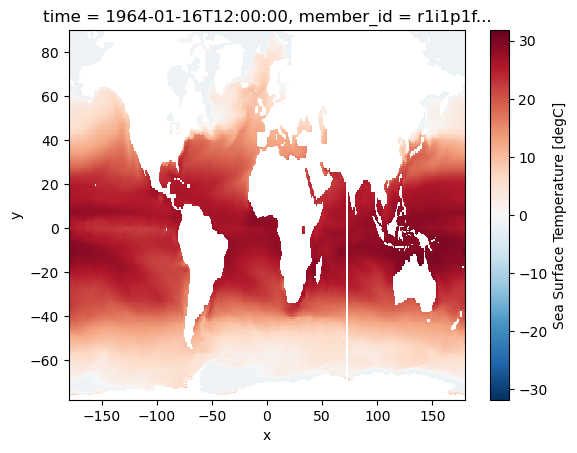

In [11]:
#If we want to create a map of the mean SST during this period, we just need one line.
sst_50yrs[0].plot()

Let's say that we would like to focus on a specific part of the world, such as Australia. We use the `sel` function again.

In [12]:
#We can use more than one variable with "sel"
sst_aus = sst_50yrs.sel(x = slice(110, 160), y = slice(-50, -5))
sst_aus

<xarray.DataArray 'tos' (time: 612, y: 58, x: 50)>
dask.array<getitem, shape=(612, 58, 50), dtype=float32, chunksize=(252, 58, 50), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float32 dask.array<chunksize=(58, 50), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(58, 50), meta=np.ndarray>
  * time            (time) datetime64[ns] 1964-01-16T12:00:00 ... 2014-12-16T...
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
  * x               (x) float64 110.5 111.5 112.5 113.5 ... 157.5 158.5 159.5
  * y               (y) float32 -49.41 -48.76 -48.09 ... -5.959 -5.545 -5.149
Attributes:
    cell_measures:       area: areacello
    cell_methods:        area: mean where sea time: mean
    description:         This may differ from "surface temperature" in region...
    history:             none
    interval_operation:  2700 s
    interval_write:      1 month
    long_name:           Sea Surface Temperature
    online_operation:    average
    standard_name:       sea_surface_temperature
    units:               degC

We can now create a map with the climatological SST mean. This map will use a Mercator projection.

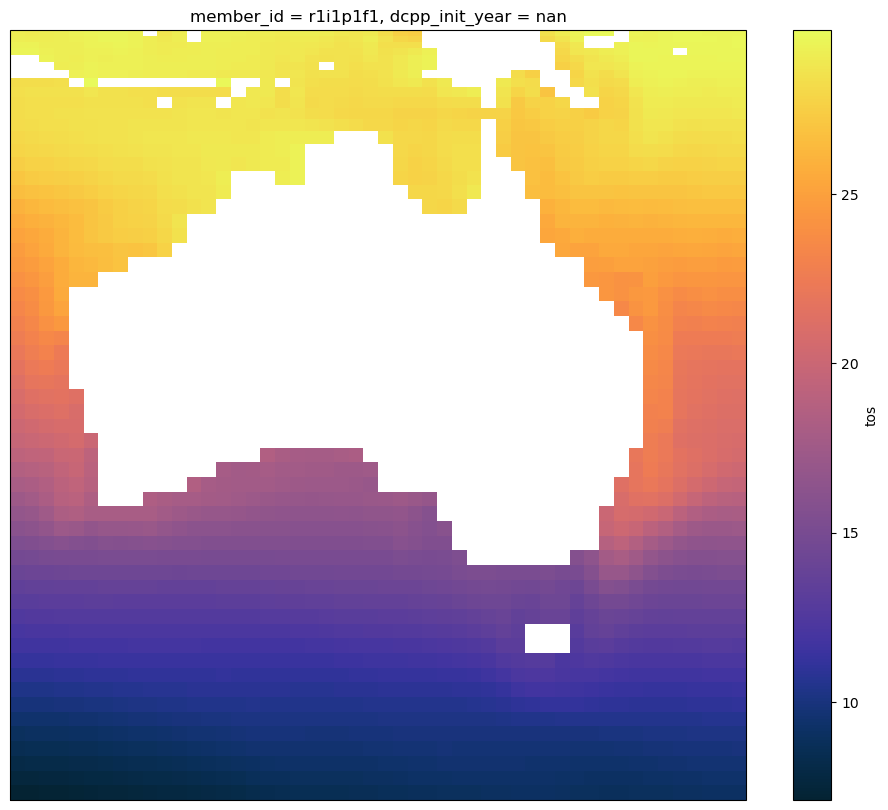

In [13]:
#Let's initialise a figure. We can even set the size of the figure.
fig = plt.figure(figsize = (12, 10))

#We define our projection to be Mercator
proj = ccrs.Mercator()

#We will add the map to the figure
ax = fig.add_subplot(1, 1, 1, projection = proj)

#We calculate the climatological mean as seen in the previous step, and plot results
sst_aus.mean('time').plot.pcolormesh(ax = ax, 
#We will use a colour map designed for temperature plots
transform = ccrs.PlateCarree(), cmap = cm.cm.thermal)

This map is looking better than our first attempt, but we can still make some improvements. We can add a layer for land and change the location and labels of the color bar.

Text(0.5, 1.0, 'Climatological sea surface temperature mean (1964-2014)')

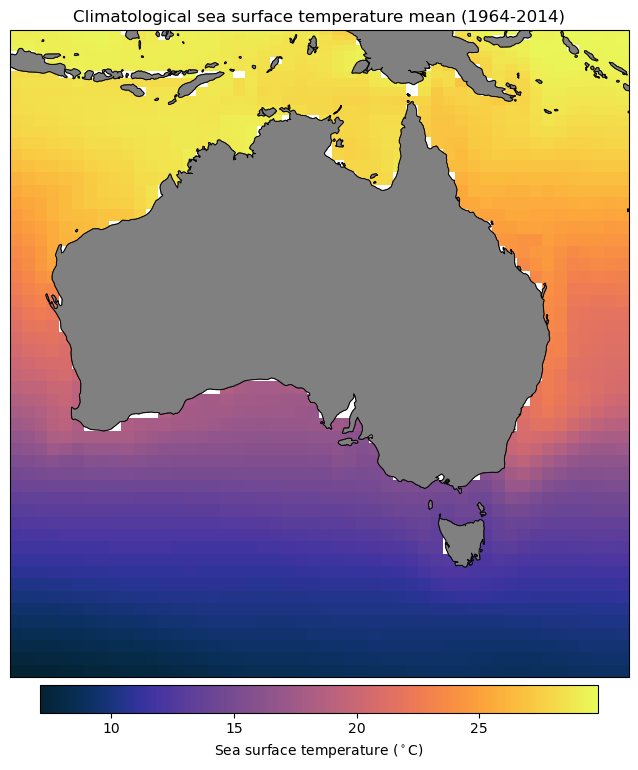

In [14]:
#We use the same base code as the previous box
#Let's initialise a figure
fig = plt.figure(figsize = (12, 10))

#We define our projection to be Mercator
proj = ccrs.Mercator()

#We will add the map to the figure
ax = fig.add_subplot(1, 1, 1, projection = proj)

#Let's add a land layer from the cartopy library
land = cft.NaturalEarthFeature('physical', 'land', '50m',
#We can change the border color and width as well as the colour of the polygon
edgecolor = 'black', linewidth = 0.5, facecolor = 'gray')

#We calculate the climatological mean as seen in the previous step, and plot results
map = sst_aus.mean('time').plot.pcolormesh(ax = ax, 
#We will use a colour map designed for temperature plots
transform = ccrs.PlateCarree(), cmap = cm.cm.thermal,
#We will remove the colourbar so we can personalise it
add_colorbar = False)


#Changing the colourbar - let's plot it horizontally
cb = fig.colorbar(map, ax = ax, orientation = 'horizontal',
#we will also reduce its size and decrease the space between the map and the bar
shrink = 0.6, pad = 0.01)

#Now we can change the color bar label
cb.ax.set_xlabel('Sea surface temperature ($^\circ$C)')

#Now we add coastlines and the land layer
ax.coastlines(resolution = '50m')
ax.add_feature(land)

#Finally we add a title
ax.set_title('Climatological sea surface temperature mean (1964-2014)')


If we are interested in calculating yearly means or seasonal means, we can use the `groupby` function to do this.

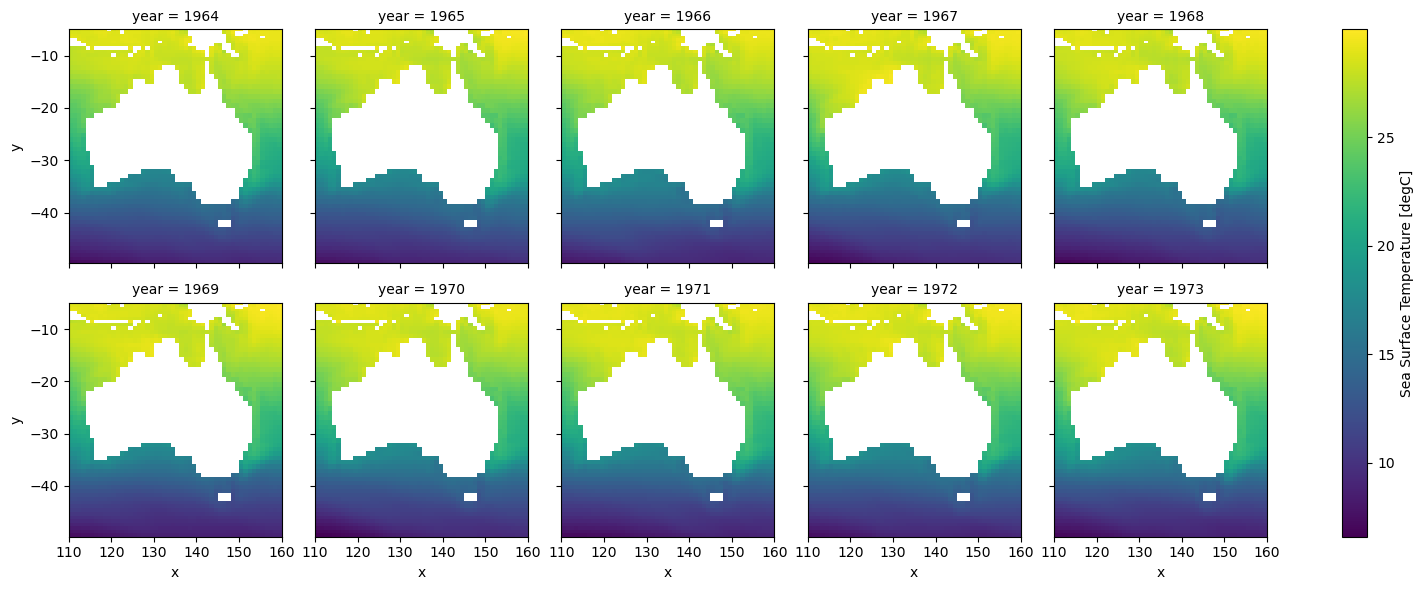

In [15]:
#Calculating annual SST means
annual_sst = sst_aus.groupby('time.year').mean('time')

#Let's check the results. We will plot only the first 10 years
annual_sst[0:10].plot(col = 'year', col_wrap = 5)

We can also summarise data to plot time series. Let's plot SST anomalies as an example.

In [16]:
#We will first calculate and save the climatological mean
aus_clim = sst_aus.mean('time')

In [17]:
#We can calculate the anomalies using the year means
anom_yrs = annual_sst-aus_clim
anom_yrs

<xarray.DataArray 'tos' (year: 51, y: 58, x: 50)>
dask.array<sub, shape=(51, 58, 50), dtype=float32, chunksize=(1, 58, 50), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float32 dask.array<chunksize=(58, 50), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(58, 50), meta=np.ndarray>
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
  * x               (x) float64 110.5 111.5 112.5 113.5 ... 157.5 158.5 159.5
  * y               (y) float32 -49.41 -48.76 -48.09 ... -5.959 -5.545 -5.149
  * year            (year) int64 1964 1965 1966 1967 ... 2011 2012 2013 2014

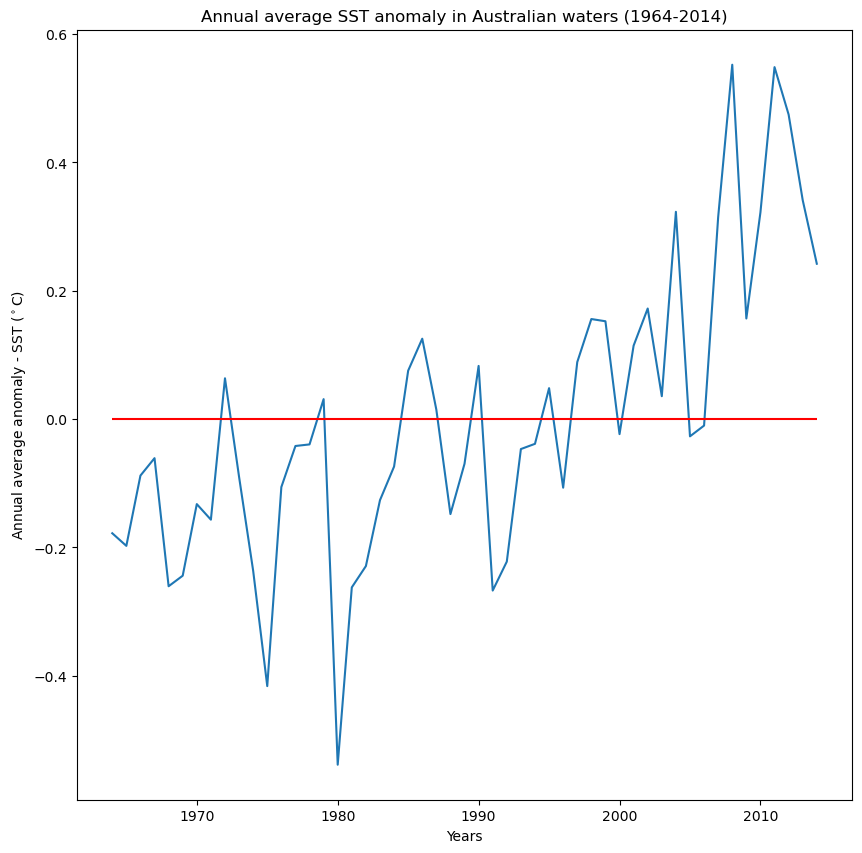

In [18]:
#We initiliase our figure
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

#Before plotting, we calculate the mean over space 
anom_yrs.mean(('x', 'y')).plot()
#Let's include a horizontal line along zero, so it is easier to see if anomalies are positive or negative
plt.hlines(0, colors = 'red', xmin = anom_yrs.year.values.min(), 
xmax =  anom_yrs.year.values.max())

#We add label names to axes
ax.set_xlabel('Years')
ax.set_ylabel('Annual average anomaly - SST ($^\circ$C)')

#We add a title to the figure
ax.set_title('Annual average SST anomaly in Australian waters (1964-2014)')

#If we like our plot, we can save the result
folder_out = 'Figure'
#We can check if a folder exists with the following line. If no folder exists, it will create one.
os.makedirs(folder_out, exist_ok = True)

fig.savefig(os.path.join(folder_out, 'AustraliaSSTanomYr_1964-2014.png'), dpi = 300)